In [1]:
import os
import cv2
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from IPython.display import display, HTML
import matplotlib.pyplot as plt
from facenet_pytorch import MTCNN

c:\Users\kenne\anaconda3\envs\deep_learning\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import torch
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", DEVICE)

Using device: cpu


In [3]:
VIDEO_DIRS = ["./train/drowsiness_separated/", "./train/non-drowsiness_separated/"]
OUTPUT_DIRS = ["./output/drowsiness_faces/", "./output/non-drowsiness_faces/"]

In [4]:
LABEL_CSV = None

In [5]:
NUM_FRAMES = 30
OUT_SIZE = (224, 224)
MARGIN = 0.35
MIN_CONFIDENCE = 0.5
KEEP_ALL = True

MTCNN_DEVICE = DEVICE
MTCNN_THRESH = 0.5

In [6]:
def sample_frame_indices(total, num):
    if total <= 0:
        return [0] * num
    idxs = np.linspace(0, total - 1, num)
    return [int(round(i)) for i in idxs]

def expand_bbox(x, y, w, h, fw, fh, frac):
    dw, dh = int(w * frac), int(h * frac)
    x0 = max(0, x - dw)
    y0 = max(0, y - dh)
    x1 = min(fw, x + w + dw)
    y1 = min(fh, y + h + dh)
    return (x0, y0, x1 - x0, y1 - y0)

def crop_and_resize(frame, bbox, out_size):
    x, y, w, h = bbox
    x2, y2 = x + w, y + h
    hF, wF = frame.shape[:2]

    x, y = max(0, x), max(0, y)
    x2, y2 = min(wF, x2), min(hF, y2)

    crop = frame[y:y2, x:x2]

    if crop.size == 0:
        # fallback
        s = min(hF, wF)
        cx, cy = wF // 2, hF // 2
        crop = frame[cy-s//2:cy+s//2, cx-s//2:cx+s//2]

    return cv2.resize(crop, out_size)


In [7]:
mtcnn = MTCNN(keep_all=True, device=str(DEVICE))

def extract_video_to_jpg(video_path, out_dir, num_frames=30, out_size=OUT_SIZE, margin=0.35):
    
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print("Cannot open:", video_path)
        return False
    
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_indices = sample_frame_indices(total_frames, num_frames)

    os.makedirs(out_dir, exist_ok=True)

    prev_bbox = None

    for idx_no, frame_idx in enumerate(frame_indices, start=1):
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
        ok, frame = cap.read()

        if not ok:
            # fallback replicate last saved frame
            if idx_no > 1:
                last_path = os.path.join(out_dir, f"{idx_no-1:02d}.jpg")
                out_path = os.path.join(out_dir, f"{idx_no:02d}.jpg")
                if os.path.exists(last_path):
                    img = cv2.imread(last_path)
                    cv2.imwrite(out_path, img)
                else:
                    blank = np.zeros((out_size[1], out_size[0], 3), np.uint8)
                    cv2.imwrite(out_path, blank)
            continue

        rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        boxes, _ = mtcnn.detect(rgb)

        if boxes is None or len(boxes) == 0:
            if prev_bbox is None:
                # center square fallback
                hF, wF = frame.shape[:2]
                s = min(hF, wF)
                cx, cy = wF//2, hF//2
                bbox = (cx - s//2, cy - s//2, s, s)
            else:
                bbox = prev_bbox
        else:
            # pick largest box
            areas = [(b[2]-b[0])*(b[3]-b[1]) for b in boxes]
            i = int(np.argmax(areas))
            x1, y1, x2, y2 = boxes[i]
            bbox = (int(x1), int(y1), int(x2 - x1), int(y2 - y1))

        bbox_exp = expand_bbox(*bbox, frame.shape[1], frame.shape[0], margin)
        face = crop_and_resize(frame, bbox_exp, out_size)
        prev_bbox = bbox_exp

        out_path = os.path.join(out_dir, f"{idx_no:02d}.jpg")
        cv2.imwrite(out_path, face)

    cap.release()
    return True

In [8]:
def batch_process_to_jpg(video_dir, output_dir, label_csv=None):
    entries = []

    if label_csv is not None:
        df = pd.read_csv(label_csv)
        if "video_filename" in df.columns and "label" in df.columns:
            entries = list(zip(df.video_filename, df.label))
        else:
            entries = [(r.iloc[0], r.iloc[1]) for _, r in df.iterrows()]
    else:
        for fn in sorted(os.listdir(video_dir)):
            if fn.lower().endswith((".mp4",".avi",".mkv",".mov",".webm")):
                entries.append((fn, ""))

    results = []

    for filename, label in tqdm(entries, desc="Extracting frames"):
        in_path = os.path.join(video_dir, filename)

        # out folder: videos/output/video_name/
        folder_name = os.path.splitext(filename)[0]
        out_folder = os.path.join(output_dir, folder_name)

        ok = extract_video_to_jpg(in_path, out_folder,
                                  NUM_FRAMES, OUT_SIZE, MARGIN)

        results.append({
            "video": filename,
            "out_folder": out_folder,
            "label": label,
            "success": ok
        })

    df = pd.DataFrame(results)
    df.to_csv(os.path.join(output_dir, "manifest.csv"), index=False)
    return df




In [9]:
def show_frames(folder, cols=6, figsize=(12,8)):
    files = sorted([f for f in os.listdir(folder) if f.endswith(".jpg")])
    rows = int(np.ceil(len(files)/cols))
    plt.figure(figsize=figsize)

    for i, fn in enumerate(files):
        img = cv2.imread(os.path.join(folder, fn))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(rows, cols, i+1)
        plt.imshow(img)
        plt.title(fn)
        plt.axis("off")

    plt.show()

Extracting frames: 100%|██████████| 60/60 [05:24<00:00,  5.40s/it]


Showing: ./output/drowsiness_faces/front_microsleep_subject_01


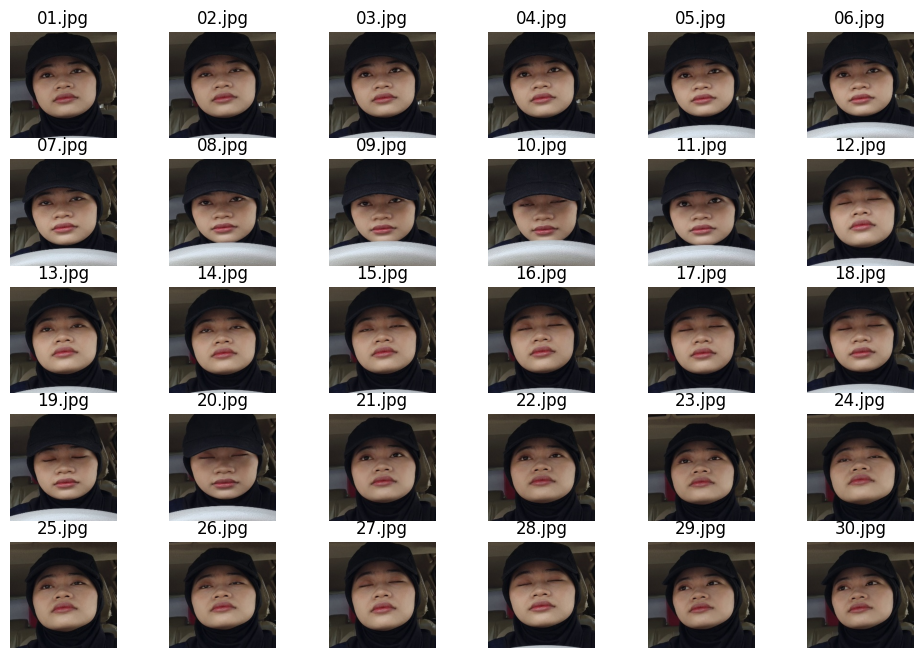

Extracting frames: 100%|██████████| 60/60 [05:54<00:00,  5.90s/it]


Showing: ./output/non-drowsiness_faces/front_focus_subject_01


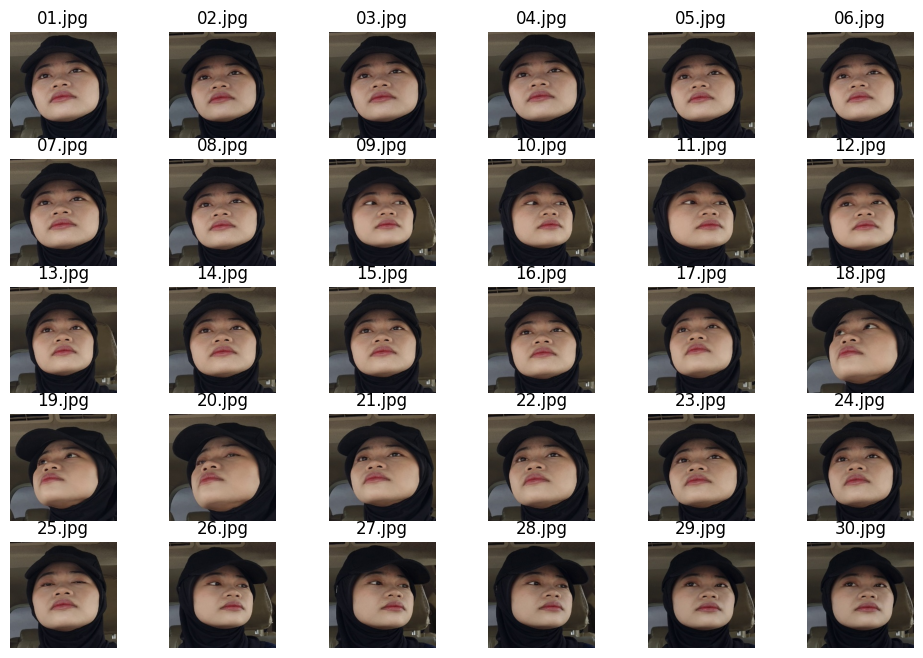

In [10]:
for VIDEO_DIR, OUTPUT_DIR in zip(VIDEO_DIRS, OUTPUT_DIRS):
    manifest = batch_process_to_jpg(VIDEO_DIR, OUTPUT_DIR, LABEL_CSV)
    manifest.head()

    first_ok = manifest[manifest.success].head(1)
    if len(first_ok) > 0:
        folder = first_ok.iloc[0].out_folder
        print("Showing:", folder)
        show_frames(folder)